### Climate skill at 1&deg;
Time-mean RMSE and bias

In [1]:
from collections import namedtuple
import copy
import re
from string import ascii_lowercase
from itertools import product

import wandb
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

from utils import wandb_to_beaker_experiment, wandb_to_beaker_result, get_wandb_scalar_metrics, savefig, get_color_scheme, DPI, FONTSIZE
from constants import INFERENCE_COMPARISON_1DEG, ERA5_BEST_INFERENCE_1YR_WANDB_RUN_IDS, WANDB_ENTITY, SECONDS_PER_DAY, WANDB_PROJECT

In [2]:
wandb_api = wandb.Api()

In [3]:
EvalVar = namedtuple('EvalVar', ['name', 'conversion_factor', 'long_name', 'units'])
EvalMetric = namedtuple('EvalMetric', ['name', 'long_name', 'units'])

In [4]:
TIME_MEAN_EVAL_VARS = [
    EvalVar('TMP2m', None, '2-meter temperature', 'K'),
    EvalVar('PRATEsfc', SECONDS_PER_DAY, 'surface precipitation rate', 'mm/day'),
    EvalVar('total_water_path', None, 'total water path', 'mm'),
    EvalVar('h500', None, '500hPa height', 'm'),
]
TIME_MEAN_METRICS = [
    EvalMetric("inference/time_mean/bias/{varname}", "Global-mean bias", None),
    EvalMetric("inference/time_mean/rmse/{varname}", "Global RMSE of time-mean", None),
    EvalMetric("inference/annual/r2/{varname}_gen", r"$R^2$ of global- and annual-mean series", '-'),
]

In [5]:
run_names_except_neuralGCM = ['ACE2-ERA5', 'ACE2-SHiELD', 'ACE2-SHiELD-RS0', 'ACE2-SHiELD-RS1', 'ACE2-SHiELD-RS3', 'ACE-climSST', 'SHiELD-reference', 'SHiELD-vs.-ERA5']
run_names_with_neuralGCM = ['ACE2-ERA5', 'ACE2-SHiELD', 'ACE-climSST', 'SHiELD-reference', 'SHiELD-vs.-ERA5', 'NeuralGCM-2020', 'ACE2-ERA5-2020']

In [6]:
all_metrics = [(eval_var, eval_metric) for eval_var, eval_metric in product(TIME_MEAN_EVAL_VARS, TIME_MEAN_METRICS)]
all_metric_names = [
    eval_metric.name.format(varname=eval_var.name)
    for eval_var, eval_metric in all_metrics
]
print(f"{all_metric_names=}")

all_metric_names=['inference/time_mean/bias/TMP2m', 'inference/time_mean/rmse/TMP2m', 'inference/annual/r2/TMP2m_gen', 'inference/time_mean/bias/PRATEsfc', 'inference/time_mean/rmse/PRATEsfc', 'inference/annual/r2/PRATEsfc_gen', 'inference/time_mean/bias/total_water_path', 'inference/time_mean/rmse/total_water_path', 'inference/annual/r2/total_water_path_gen', 'inference/time_mean/bias/h500', 'inference/time_mean/rmse/h500', 'inference/annual/r2/h500_gen']


In [7]:
metrics = {}

INFERENCE_COMPARISON_1DEG['10yr']['ACE2-ERA5-2020'] = ERA5_BEST_INFERENCE_1YR_WANDB_RUN_IDS

for duration_name, duration_group in INFERENCE_COMPARISON_1DEG.items():
    for run_group_name, run_group in duration_group.items():
        for ic_name, run_id in run_group.items():
            if '-' in ic_name:
                ic_name = ic_name.split('-')[1]
            full_key = '/'.join([duration_name, run_group_name, ic_name])
            print(f"Getting metrics for {full_key=}.")
            run = wandb_api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_id}")
            metrics[full_key] = get_wandb_scalar_metrics(run, all_metric_names)

Getting metrics for full_key='10yr/ACE2-ERA5/IC0'.
Getting metrics for full_key='10yr/ACE2-ERA5/IC1'.
Getting metrics for full_key='10yr/ACE2-ERA5/IC2'.
Getting metrics for full_key='10yr/ACE2-SHiELD/IC0'.
Getting metrics for full_key='10yr/ACE2-SHiELD/IC1'.
Getting metrics for full_key='10yr/ACE2-SHiELD/IC2'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS0/IC0'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS0/IC1'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS0/IC2'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS1/IC0'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS1/IC1'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS1/IC2'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS3/IC0'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS3/IC1'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS3/IC2'.
Getting metrics for full_key='10yr/SHiELD-reference/IC0'.
Getting metrics for full_key='10yr/SHiELD-reference/IC1'.
Getting metrics for full_key='10yr/SHiELD-reference/IC2'.
G

In [8]:
ic_key = '/IC[0-9]*$'
duration_key = '^[0-9]*yr/'
das = []
for run_name, run_metrics in metrics.items():
    run_coords = {}
    ic_match = re.search(ic_key, run_name)
    if ic_match:
        trimmed_run_name = run_name[0:ic_match.span()[0]]
        run_coords['IC'] = [ic_match.group().strip('/')]
    else:
        trimmed_run_name = run_name
    duration_match = re.search(duration_key, trimmed_run_name)
    if duration_match:
        trimmed_run_name = trimmed_run_name[duration_match.span()[1]:]
        run_coords['duration'] = [duration_match.group().strip('/')]
    else:
        trimmed_run_name = trimmed_run_name
    metric_names, metric_values = zip(*run_metrics.items())
    run_da = xr.DataArray(list(metric_values), dims='metric', coords={'metric': list(metric_names)}, name=trimmed_run_name)
    das.append(run_da.expand_dims(run_coords))
all_metrics_ds = xr.merge(das) 

### Insert NeuralGCM metric
From paper, PWAT time-mean RMSE is 1.09 mm. Figure 4 https://www.nature.com/articles/s41586-024-07744-y


In [9]:
all_metrics_ds['NeuralGCM-2020'] = xr.full_like(all_metrics_ds['ACE2-ERA5'], fill_value=np.nan)
all_metrics_ds['NeuralGCM-2020'].loc[{'metric': 'inference/time_mean/rmse/total_water_path'}] = 1.09

# also only include ACE2-ERA5-1yr metrics that compare against NeuralGCM
ace2_era5_2020 = all_metrics_ds['ACE2-ERA5-2020'].copy()
all_metrics_ds['ACE2-ERA5-2020'] = xr.full_like(all_metrics_ds['ACE2-ERA5'], fill_value=np.nan)
all_metrics_ds['ACE2-ERA5-2020'].loc[{'metric': 'inference/time_mean/rmse/total_water_path'}] = ace2_era5_2020.sel({'metric': 'inference/time_mean/rmse/total_water_path'})

In [10]:
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE)
plt.rc('axes', labelsize=(FONTSIZE - 2))
plt.rc('xtick', labelsize=(FONTSIZE - 2))
plt.rc('ytick', labelsize=(FONTSIZE - 2))
plt.rc('figure', dpi=DPI)

# The color scheme that shows up across multiple figures needs to distinguish the following:
# ACE2-ERA5, ACE2-SHiELD, ACE-climSST, neuralGCM, SHiELD reference, ERA5 vs SHiELD
# the three ACE versions also get plotted as line plots so they need to be distinct

n_colors_ace = 3 # 3 ACE versions
i_color_repeat = 1
n_repeats = 4 # 4 ACE2-SHiELD seeds
cmap_start = 0.1 # avoid pale yellow
ace_color_scheme = xr.DataArray(
    get_color_scheme(n_colors_ace, i_color_repeat=i_color_repeat, n_repeats=n_repeats, cmap_start=cmap_start),
    dims=['run_group', 'rgba'],
)
ace_no_seeds_color_scheme = xr.DataArray(
    get_color_scheme(n_colors_ace, cmap_start=cmap_start),
    dims=['run_group', 'rgba'],
)

n_colors_baseline = 3
cmap_baseline = 'Greys'
cmap_start_baseline = 0.3 # avoid light gray
cmap_end_baseline = 0.6 # avoid black
baselines_color_scheme = xr.DataArray(
    get_color_scheme(
        n_colors_baseline,
        cmap_name=cmap_baseline,
        cmap_start=cmap_start_baseline,
        cmap_end=cmap_end_baseline
    ),
    dims=['run_group', 'rgba']
)
baselines_no_neuralGCM_color_scheme = baselines_color_scheme.isel(run_group=slice(None, 2))

color_scheme_except_neuralGCM = xr.concat([ace_color_scheme, baselines_no_neuralGCM_color_scheme], dim='run_group')
color_scheme_with_neuralGCM = xr.concat(
    [
        ace_no_seeds_color_scheme, #ACE2
        baselines_color_scheme, # baselines including NeuralGCM
        ace_color_scheme.isel(run_group=0), # ACE2-ERA5-1yr
    ],
    dim='run_group'
)

FIGSIZE = [1.27 * dim for dim in [5.5, 2]] # should be [5.5, 2], but need to scale up for unknown font size reasons

In [11]:
def plot_bars(metrics_ds, plot_vars, plot_metric, color_scheme, figsize=FIGSIZE, convert=True, ylim=None):
    nrows, ncols = 1, len(plot_vars)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if len(plot_vars) == 1:
        # if only plotting one variable
        axes = np.array([axes])
    for i, variable in enumerate(plot_vars):
        full_metric_name = plot_metric.name.format(varname=variable.name)
        ax = axes[i]
        metric_ds = metrics_ds.sel(metric=full_metric_name).copy()
        if convert and variable.conversion_factor is not None:
            metric_ds = metric_ds * variable.conversion_factor
        metric_da = (
            metric_ds
            .to_array(dim='run_group', name=full_metric_name)
            .drop_vars(['metric', 'duration'], errors=False)
        )
        # drop null (all ICs nan) values before bar plot; adjust colors accordingly
        color_scheme_variable = color_scheme.where(~np.isnan(metric_da.mean('IC')), drop=True)
        metric_da = metric_da.dropna(dim='run_group', how='all')
        # plot mean of ICs with std dev errorbars
        metric_ic_mean = metric_da.mean('IC')
        n_ics = (~np.isnan(metric_da)).sum('IC')
        std_dev_correction = np.sqrt(n_ics / (n_ics - 1))
        yerr = 1.96 * std_dev_correction * metric_da.std('IC')
        metric_ic_mean.to_series().plot.bar(
            yerr=yerr,
            ax=ax,
            color=color_scheme_variable.values,
            error_kw=dict(
                capsize=3,
                capthick=0.5,
                linewidth=0.5,
                ecolor='k'),
            linewidth=0.5,
            edgecolor='k',
            legend=False,
            zorder=10,
        )
        ax.plot([-1, len(metric_ic_mean)], [0, 0], 'k-', linewidth=1, zorder=20)
        ax.set_xlabel(None)
        units = variable.units if plot_metric.units is None else plot_metric.units
        ax.set_ylabel(f"{plot_metric.long_name} [{units}]")
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid(axis='y', which='both', alpha=0.4, zorder=0)
        ax.set_title(f"{ascii_lowercase[i]}) {variable.long_name}")
        # want hyphens for the ACE2-* models but not for the others
        ax.set_xticklabels(
            [
                varname.item().replace('-', ' ')
                if varname.item().startswith('SHiELD')
                else varname.item()
                for varname in metric_ic_mean.run_group
            ],
            rotation=75
        )
    fig.tight_layout()
    return fig

### Plot time-mean and global-mean bias for 10-year runs

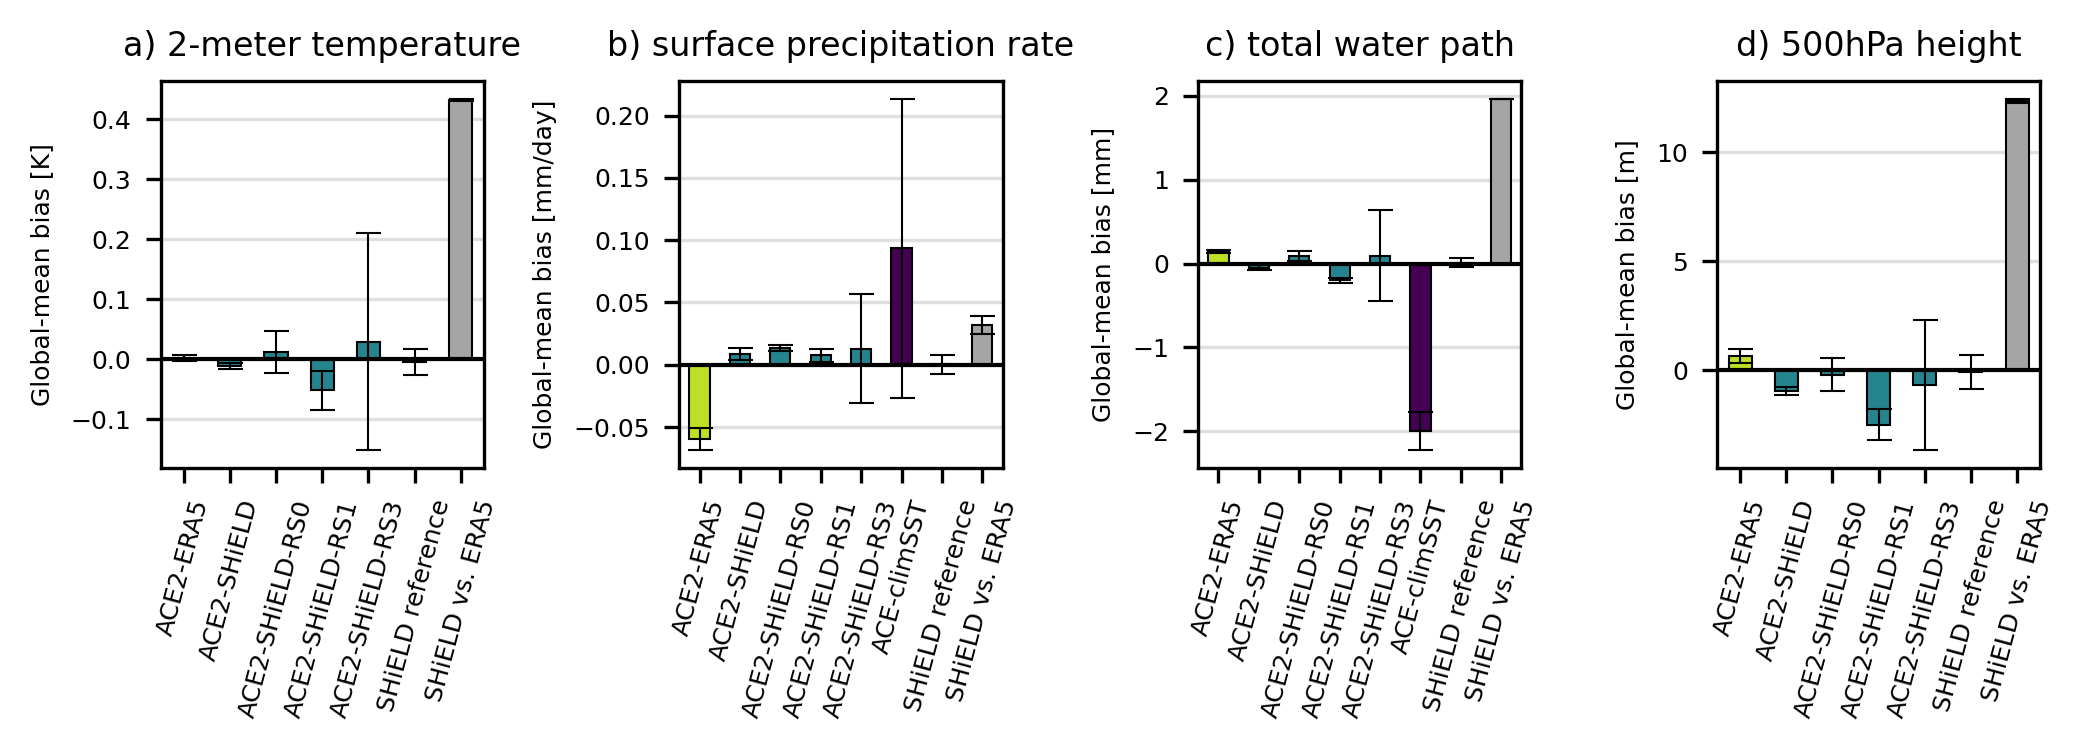

In [12]:
plot_metric = TIME_MEAN_METRICS[0] # bias
plot_vars = TIME_MEAN_EVAL_VARS
duration = '10yr'
fig = plot_bars(all_metrics_ds[run_names_except_neuralGCM].sel(duration=duration), plot_vars, plot_metric, color_scheme_except_neuralGCM)

### Plot RMSE of time-mean for 10-year runs

Here we include NeuralGCM since we have a data point for total water path. We also make a version without all the ACE2-SHiELD random seed ensemble members, since it is confusing.

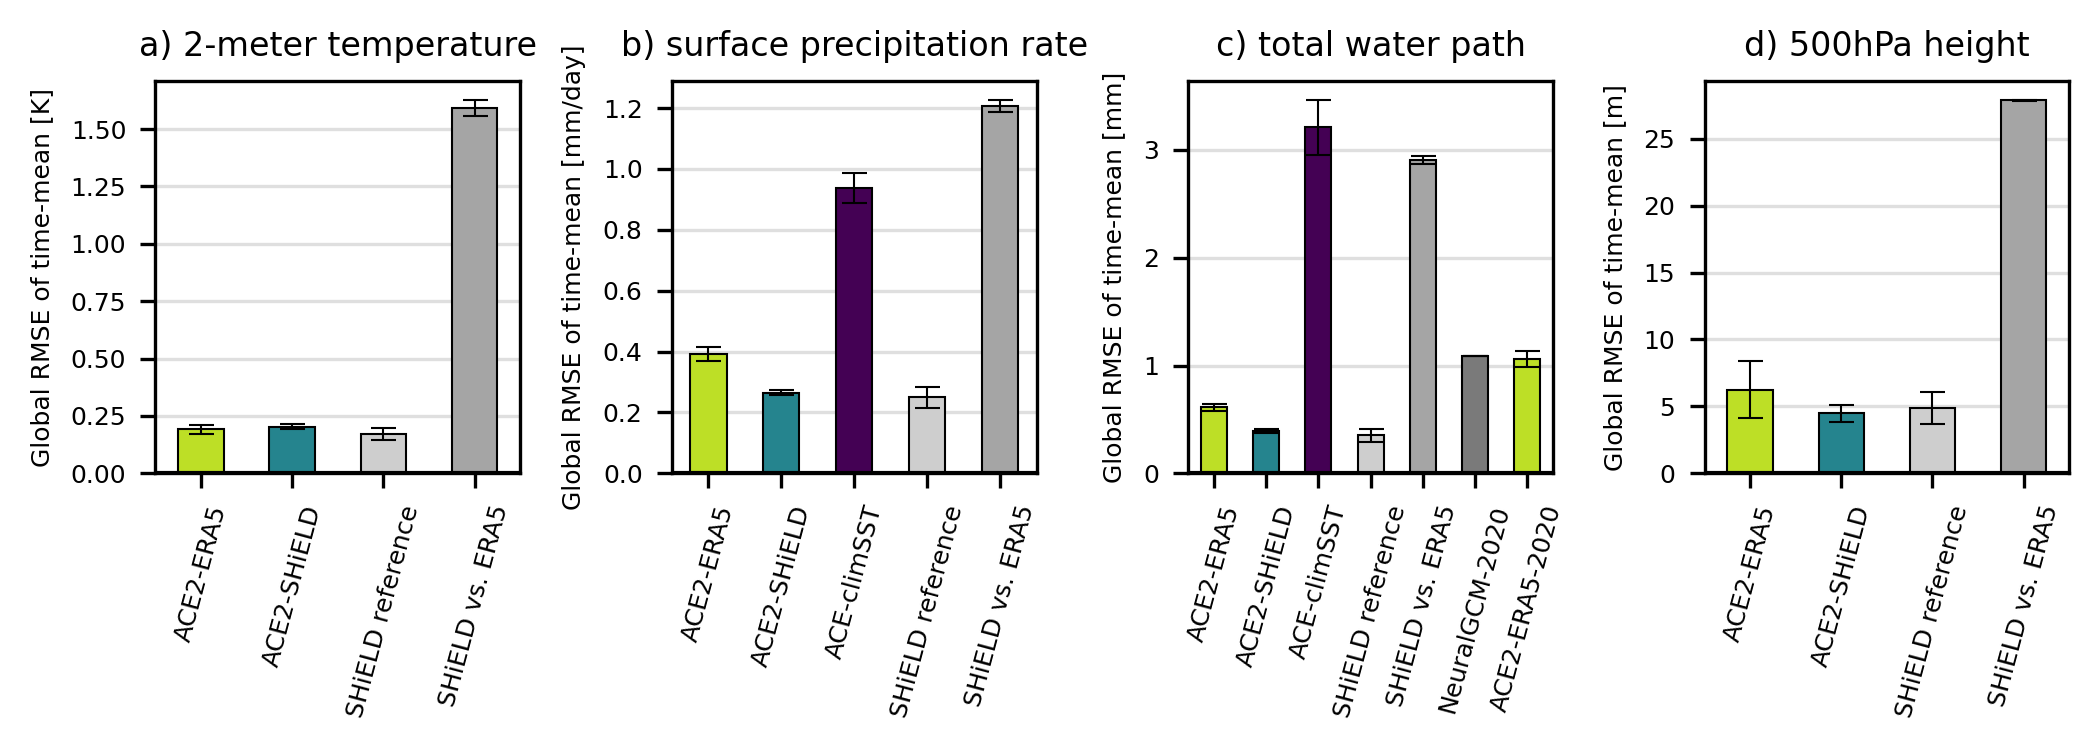

In [13]:
plot_metric = TIME_MEAN_METRICS[1] # RMSE
plot_vars = TIME_MEAN_EVAL_VARS
duration = '10yr'
fig = plot_bars(
    all_metrics_ds[run_names_with_neuralGCM].sel(duration=duration),
    plot_vars,
    plot_metric,
    color_scheme_with_neuralGCM,
    ylim=(0, None)
)
savefig(fig, 'climate_skill_1deg_time_mean_RMSE_10yr.png')

For completeness, also show for other set of runs without NeuralGCM

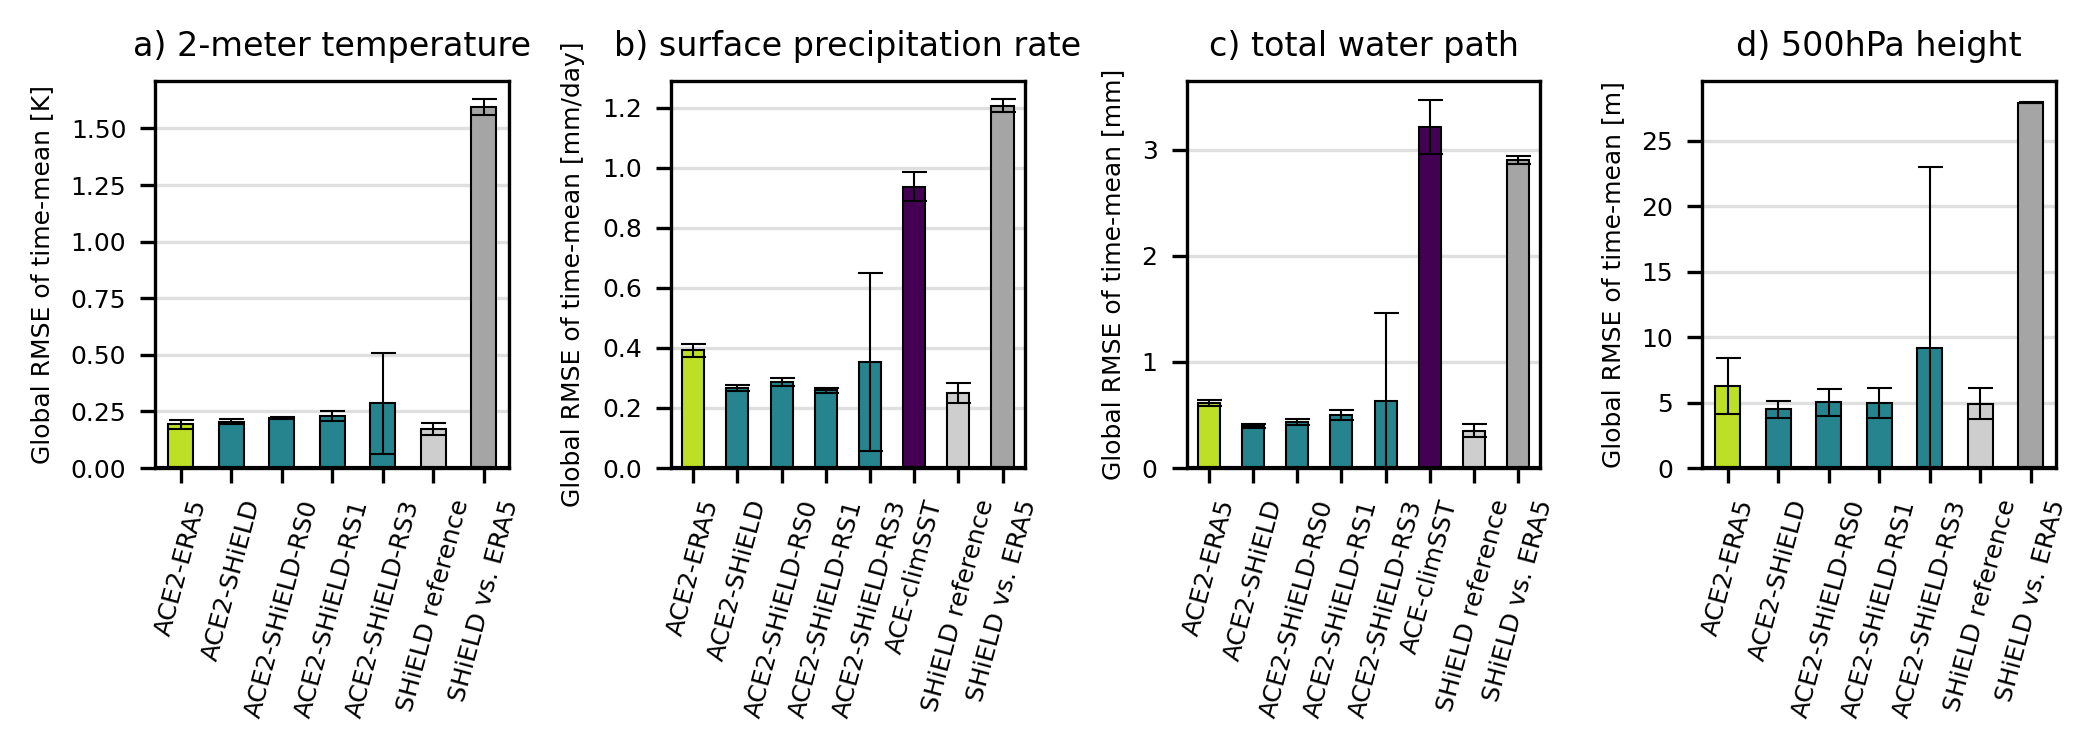

In [14]:
plot_metric = TIME_MEAN_METRICS[1] # RMSE
plot_vars = TIME_MEAN_EVAL_VARS
duration = '10yr'
fig = plot_bars(
    all_metrics_ds[run_names_except_neuralGCM].sel(duration=duration),
    plot_vars,
    plot_metric,
    color_scheme_except_neuralGCM,
    ylim=(0, None)
)
savefig(fig, 'climate_skill_1deg_time_mean_RMSE_10yr_with_rs_ensemble.png')

### Plot time-mean and global-mean bias for 81-year runs

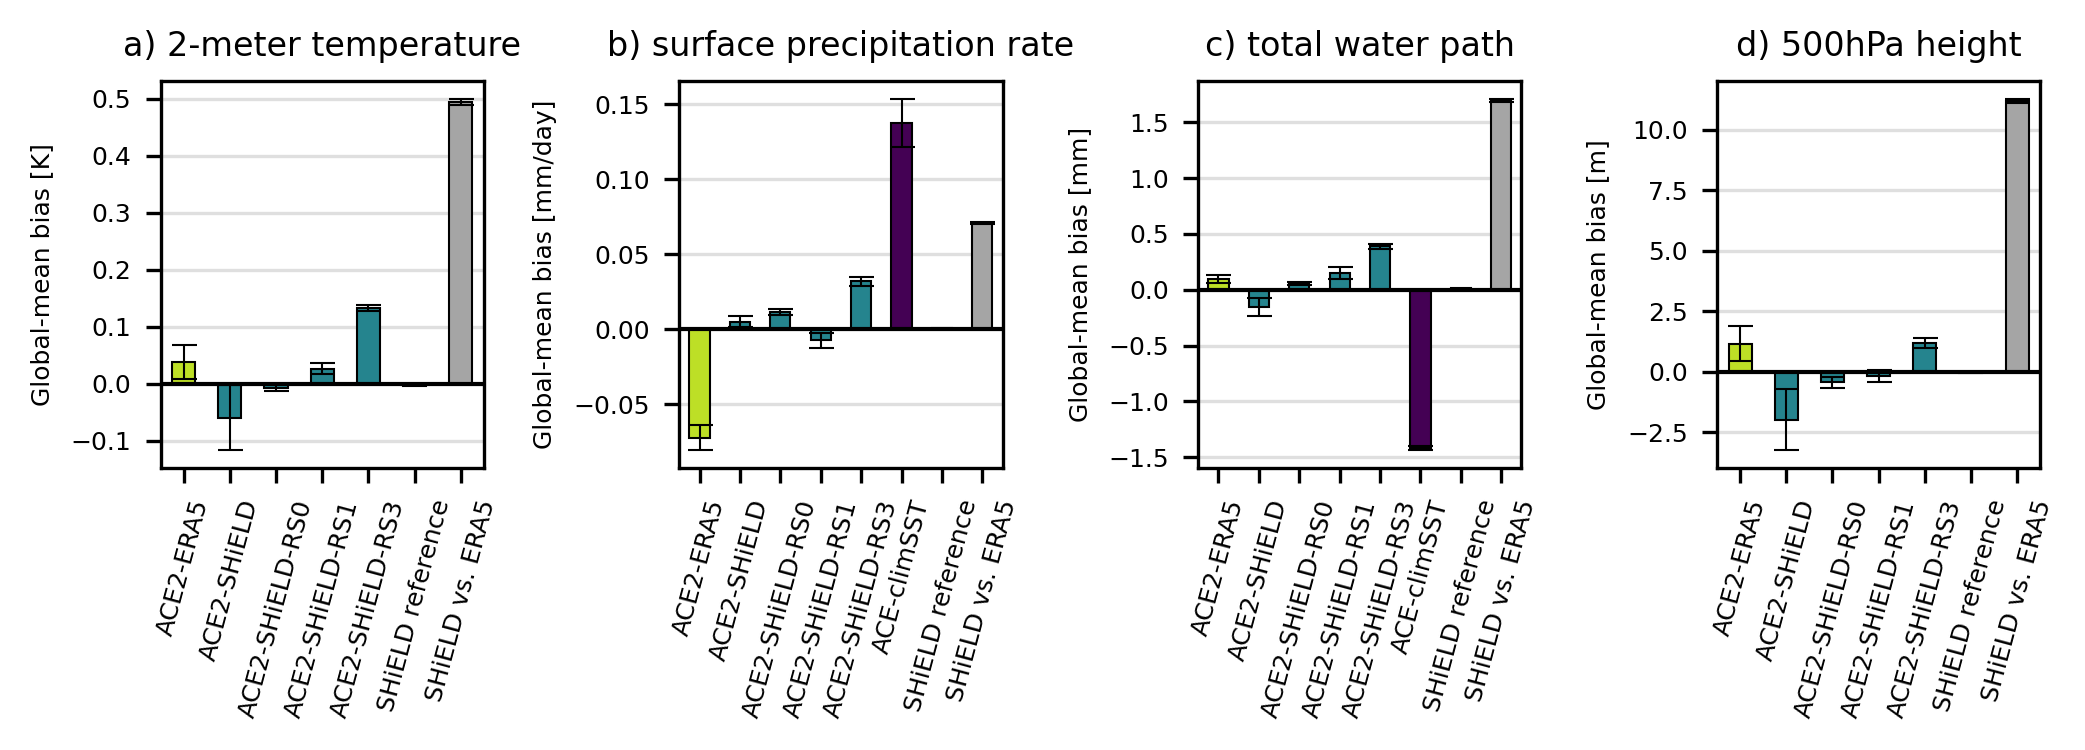

In [15]:
plot_metric = TIME_MEAN_METRICS[0] # bias
plot_vars = TIME_MEAN_EVAL_VARS
duration = '81yr'
fig = plot_bars(
    all_metrics_ds[run_names_except_neuralGCM].sel(duration=duration),
    plot_vars,
    plot_metric,
    color_scheme_except_neuralGCM
)

### Plot RMSE of time-mean for 81-year runs

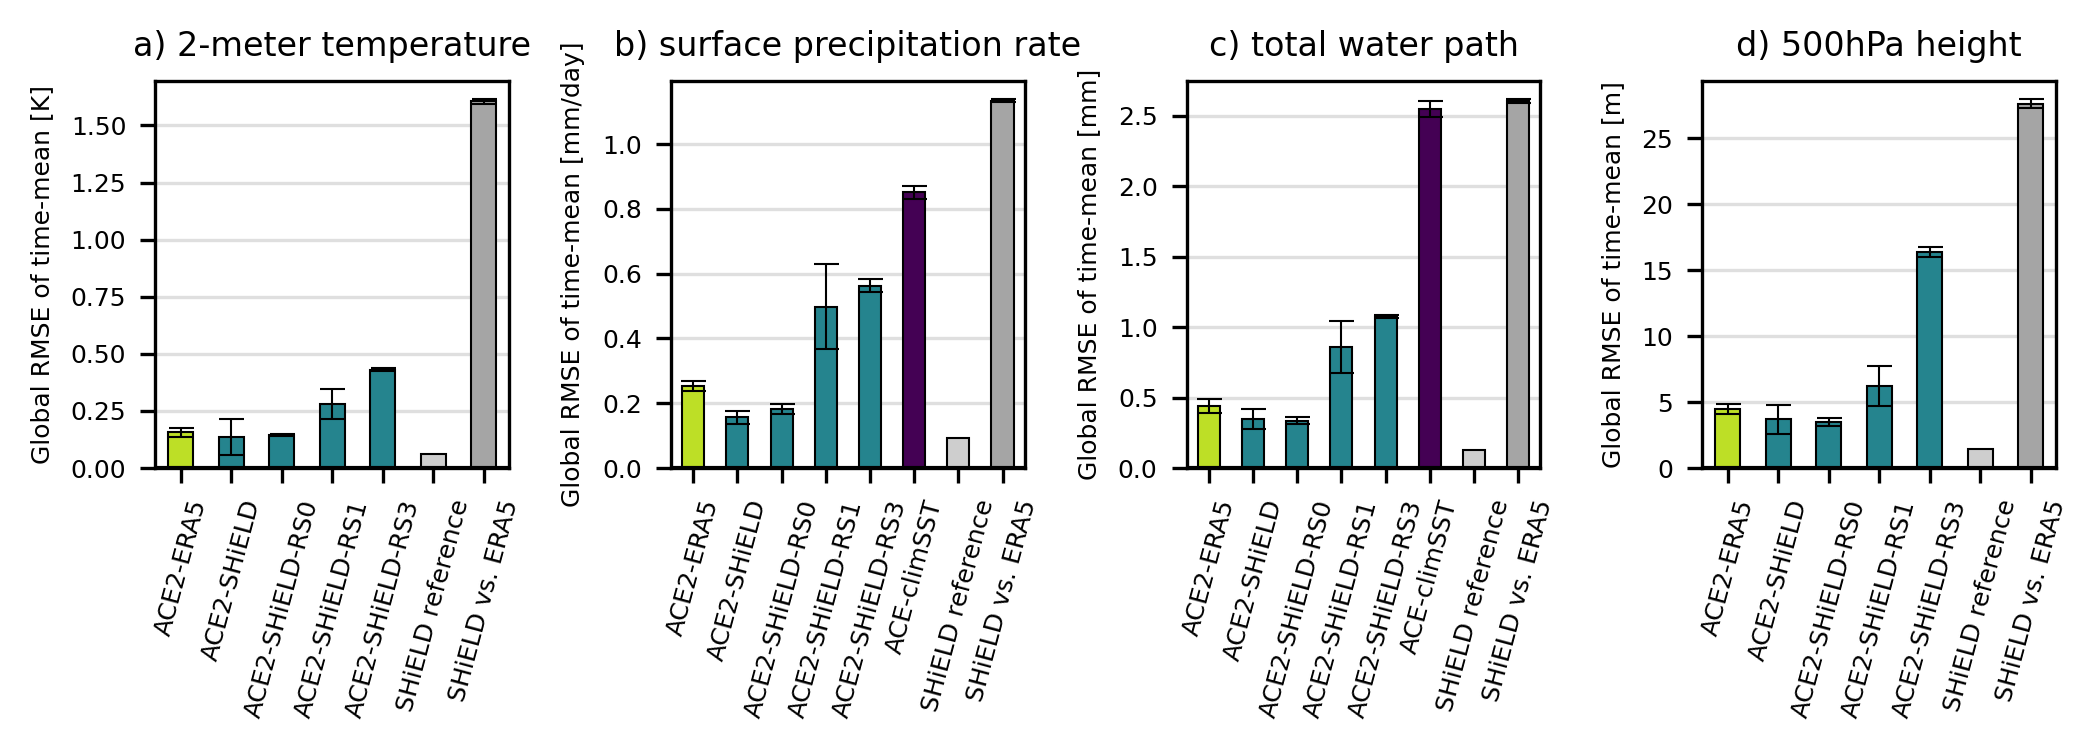

In [16]:
plot_metric = TIME_MEAN_METRICS[1] # RMSE
plot_vars = TIME_MEAN_EVAL_VARS
duration = '81yr'
fig = plot_bars(
    all_metrics_ds[run_names_except_neuralGCM].sel(duration=duration), 
    plot_vars, 
    plot_metric,
    color_scheme_except_neuralGCM
)